# Prepare data for LM

In [7]:
import pandas as pd 
from pathlib import Path
from fastai import *
from fastai.text import *
import operator

In [2]:
from toxic import preprocess_text

In [3]:
# data
path = Path('/home/jupyter/toxic')
clas_csv_file = 'toxic_train.csv'
test_csv_file = 'toxic_test.csv'

# pretrained
encoder_file = 'fine_tuned_encoder_basic_toxic_lm15ep_extended'
data_lm_file = 'data_lm_basic_toxic_extended.pkl'

# results
exp_nb = 2
model_cv_result_file = 'toxic_test_cv_{}'
model_prod_cv_result_file = 'toxic_production_cv_{}'
k_folds_file = 'holdout_and_k_folds_idxs_exp_nb_{}.pkl'.format(exp_nb)
models_performance_file = 'toxic_CV_models_performance_exp_nb_{}.pkl'.format(exp_nb)
submission_predictions = 'toxic_CV_submission_exp_nb_{}.csv'.format(exp_nb)

final_model_result_file = 'toxic_final_model_{}'.format(exp_nb)
final_model_prod_result_file = 'toxic_production_final_{}'.format(exp_nb)
final_submission_predictions = 'toxic_final_submission_exp_nb_{}.csv'.format(exp_nb)

In [4]:
df_train_initial_ = pd.read_csv(path/clas_csv_file)[:1000]

In [5]:
preprocesed_df = preprocess_text.preprocess_text_col(df_train_initial_, 'comment_text')

100%|██████████| 1000/1000 [00:00<00:00, 51521.38it/s]


In [6]:
preprocesed_df['comment_text'][0]

"this is so cool . it is like , ' would you want your mother to read this ? ? ' really great idea , well done ! "

# Loss functions

In [333]:
class L1LossFlat(nn.L1Loss):
  "Mean Absolute Error Loss"
  def forward(self, input:Tensor, target:Tensor) -> Rank0Tensor:
    return super().forward(input.view(-1), target.view(-1))

In [41]:
path = Path('/home/jupyter/toxic')
csv_file = 'combined_langauge_model_data.csv'

In [16]:
df = pd.read_csv(path/csv_file)
#df['class_targets'] = df['target'].apply(lambda x: 1 if x >= 0.5 else 0)

KeyboardInterrupt: 

# Create DataBunch for Language Model

In [19]:
bs=40

In [20]:
data_lm = (TextList.from_csv(path, csv_file, cols='comment_text')
                .split_by_rand_pct(0.1)
                .label_for_lm()
                .databunch(bs=bs))

KeyboardInterrupt: 

In [40]:
data_lm.save('data_lm_basic_toxic_extended.pkl')

In [21]:
data_lm = load_data(path, 'data_lm_basic_toxic_extended.pkl', bs=bs)

In [22]:
data_lm.show_batch()

# Language Model

In [23]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=True, drop_mult=0.3)

In [152]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


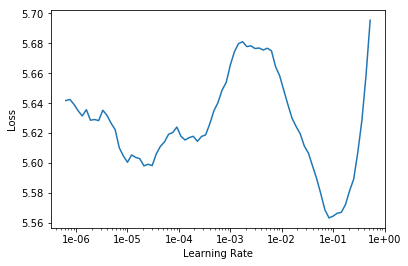

In [153]:
learn.recorder.plot(skip_end=15)

In [154]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

In [155]:
learn.save('fit_head_basic_toxic_lm1ep_extended')

In [24]:
learn.load('fit_head_basic_toxic_lm1ep_extended');

In [25]:
learn.unfreeze()

In [27]:
learn.fit_one_cycle(15, 1e-3, moms=(0.8,0.7))

In [35]:
learn.save('fine_tuned_basic_toxic_lm15ep_extended')

In [47]:
learn.load('fine_tuned_basic_toxic_lm15ep_extended')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (1993358 items)
x: LMTextList
xxbos xxmaj this is such an urgent design problem ; kudos to you for taking it on . xxmaj very impressive !,xxbos xxmaj is this something i 'll be able to install on my site ? xxmaj when will you be releasing it ?,xxbos ur a xxunk comment .,xxbos xxunk suck it .,xxbos xxrep 4 f xxrep 15 u
y: LMLabelList
,,,,
Path: /home/jupyter/toxic;

Valid: LabelList (221484 items)
x: LMTextList
xxbos xxmaj from the article ( xxup lmao btw ) : " xxmaj the xxmaj white xxmaj house declined to comment . xxmaj robert xxmaj xxunk , a lawyer for xxmaj flynn , declined to comment . xxmaj the xxmaj russian embassy did not respond to requests for comment . " 
  . 
  " 125 xxmaj days : xxmaj donald xxmaj trump xxmaj makes xxmaj one xxmaj last xxmaj try xxmaj to xxmaj patch xxmaj things xxmaj up xxmaj with xxmaj comey " 
  https : / / www.youtube.com / xxunk,xxbos subnational entities that recognise it as such us states,xxbos 

In [34]:
learn.save_encoder('fine_tuned_encoder_basic_toxic_lm15ep_extended')

In [37]:
TEXT = "You fucking jew"
N_WORDS = 20
N_SENTENCES = 3

In [39]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.25) for _ in range(N_SENTENCES)))

You fucking jew - hating Jews are the ones who are the problem . You are the problem . xxbos
You fucking jew . xxbos The American Dream is a Republican Party . It 's a
You fucking jew 's are a bunch of idiots . xxbos The Globe and Mail is a joke .


In [ ]:
import pickle
with open('fine_tuned_basic_toxic_vocab_lm15ep_extended.pcl', 'wb') as f:
    pickle.dump(data_lm.vocab, f)

In [44]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


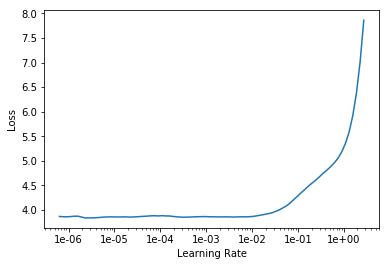

In [45]:
learn.recorder.plot()

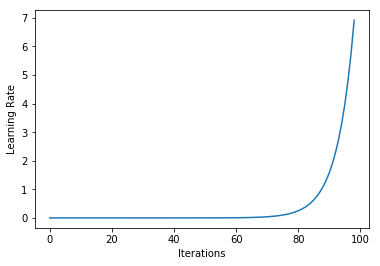

In [48]:
learn.recorder.plot_lr()

# Cross validation split

### stratified cross validation
- find a way to do it on regression OR split by 0.5 > target as class

In [466]:
def get_k_stratified_folds_indexes_given_continues_variable(df, k_folds, continuous_target_col_name):
    nb_samples = df.shape[0]
    split_remainder = nb_samples%k_folds
    
    idxs_train_remainder = df[:split_remainder].index.values
    idxs_train_trimmed = df[split_remainder:]

    idxs_train_sorted = idxs_train_trimmed.sort_values(by=continuous_target_col_name).index.values

    k_groups = np.split(idxs_train_sorted, k_folds)
    list(map(np.random.shuffle, k_groups))
    folds_idxs = [np.array(x) for x in zip(*k_groups)]
    folds_idxs[0] = np.concatenate([folds_idxs[0], idxs_train_remainder])
    
    return np.array(folds_idxs)

In [367]:
df_train_initial = pd.read_csv('toxic_train.csv')[:115]

KeyboardInterrupt: 

In [467]:
SEED = 777

df_train_initial = df_train_initial.sample(frac=1 ,random_state=SEED)

k_folds = 10
target_col_name = 'target'

folds_idxs = get_k_stratified_folds_indexes_given_continues_variable(df_train_initial, k_folds, target_col_name)

In [453]:
holdout_idx = folds_idxs.pop(0)

In [385]:
holdout_idx

(88, 100, 42, 45, 67, 86, 26, 30, 62, 13, 43, 68, 72, 57, 96)

In [472]:
folds_idxs

array([array([102, 113,   0, 100,  56,  43,  87, 108,  48,  14,  44,  15,   2,  17,  31]),
       array([ 67,  88,  10,  60,  28,   8, 114,  22,  59,  84]),
       array([ 78,  68, 104,   9, 107,  21, 101,  20,  46,   5]),
       array([ 38,  55,  80,   3,   7,  77,  76, 103,  62,  11]), array([54, 49, 92, 98, 73, 91, 41, 57, 83, 34]),
       array([  1, 106,  37,  12,  61, 111,  47,  64,  89,   6]),
       array([ 72,  24,  99,  63,  30, 109,  16,  35,  58,   4]), array([93, 25, 18, 32, 70, 33, 74, 40, 39, 13]),
       array([81, 95, 42, 27, 97, 53, 50, 45, 75, 19]), array([112,  79,  86,  51,  23,  29,  69, 110,  65,  82]),
       array([ 36,  85,  52,  66,  96,  71,  26,  90,  94, 105])], dtype=object)

In [400]:
df_train_initial.loc[[*holdout_idx]]

id  target                                       comment_text  \
88   239704     0.0  I think Wweek is in a strange spot with that. ...   
100  239722     0.0  Loving this collection. Cant wait till Season ...   
42   239628     0.0  Awesome! Signed up just to give this a shot......   
45   239633     0.0  I haven't seen the kind of comments you're men...   
67   239667     0.0  Thanks so much for your input, and for giving ...   
86   239702     0.0  Did you even go on Hawthorne, or only Yelp it?...   
26   239602     0.0  Thanks, Christa!  Will you be adding any featu...   
30   239606     0.0  Why bother writing a review if it's going to b...   
62   239659     0.3  I couldn't be more pleased. Comments on many s...   
13   239583     0.6  It's ridiculous that these guys are being call...   
43   239631     0.0  disqus has way more functionality and obviousl...   
68   239669     0.0  I think you left out one very important organi...   
72   239673     0.0  Ryan Bundy seems like a nice, responsible  hum...   
57   239652     0.0  The letter writing campaign to get livestock o...   
96   239718     0.0  Hi David, we did consider all of these possibi...   

     severe_toxicity  obscene  identity_attack  insult  threat  asian  \
88               0.0      0.0              0.0     0.0     0.0    NaN   
100              0.0      0.0              0.0     0.0     0.0    NaN   
42               0.0      0.0              0.0     0.0     0.0    NaN   
45               0.0      0.0              0.0     0.0     0.0    NaN   
67               0.0      0.0              0.0     0.0     0.0    NaN   
86               0.0      0.0              0.0     0.0     0.0    NaN   
26               0.0      0.0              0.0     0.0     0.0    NaN   
30               0.0      0.0              0.0     0.0     0.0    NaN   
62               0.0      0.0              0.0     0.3     0.0    NaN   
13               0.0      0.1              0.0     0.6     0.1    NaN   
43               0.0      0.0              0.0     0.0     0.0    NaN   
68               0.0      0.0              0.0     0.0     0.0    0.0   
72               0.0      0.0              0.0     0.0     0.0    NaN   
57               0.0      0.0              0.0     0.0     0.0    NaN   
96               0.0      0.0              0.0     0.0     0.0    NaN   

     atheist  ...  article_id    rating  funny  wow  sad  likes  disagree  \
88       NaN  ...       26795  approved      0    0    0      1         0   
100      NaN  ...       26269  approved      0    0    0      0         0   
42       NaN  ...       26795  approved      0    0    0      2         0   
45       NaN  ...       26795  approved      0    0    0      2         0   
67       NaN  ...       26795  approved      0    0    0      0         0   
86       NaN  ...       26597  approved      0    0    0      0         0   
26       NaN  ...       26795  approved      0    0    0      1         0   
30       NaN  ...       26655  approved      0    0    0      1         0   
62       NaN  ...       26795  approved      0    0    0     12         0   
13       NaN  ...       26670  approved      0    0    0      3         0   
43       NaN  ...       26795  approved      0    0    0      0         0   
68       0.0  ...       27081  approved      0    0    0      1         0   
72       NaN  ...       26670  approved      0    0    0      1         0   
57       NaN  ...       26662  approved      0    0    0      2         0   
96       NaN  ...       26795  approved      0    0    0      0         0   

     sexual_explicit  identity_annotator_count  toxicity_annotator_count  
88               0.0                         0                         4  
100              0.0                         0                         4  
42               0.0                         0                         4  
45               0.0                         0                         4  
67               0.0                         0 

In [411]:
df_train_initial

id    target                                       comment_text  \
43   239631  0.000000  disqus has way more functionality and obviousl...   
68   239669  0.000000  I think you left out one very important organi...   
72   239673  0.000000  Ryan Bundy seems like a nice, responsible  hum...   
57   239652  0.000000  The letter writing campaign to get livestock o...   
96   239718  0.000000  Hi David, we did consider all of these possibi...   
79   239690  0.000000  let me some up the heavy vibers feelings:\n\nG...   
33   239611  0.000000                             Troll free since 2016.   
38   239624  0.000000  Interesting concept.\n\nHow does Civil Comment...   
26   239602  0.000000  Thanks, Christa!  Will you be adding any featu...   
73   239674  0.000000  All the framed boxes must take up extra code a...   
86   239702  0.000000  Did you even go on Hawthorne, or only Yelp it?...   
83   239698  0.400000  AND Left wing trolls!\n\nJust because someone ...   
77   239682  0.000000  Hey i5guy, that's a good point about "more rep...   
99   239721  0.000000  Sorry, Rod, you'll have to be Mr_Whiskers or M...   
48   239637  0.200000  Thank you, thank you, thank you! I love WW con...   
11   239579  0.440000  This is a great story. Man. I wonder if the pe...   
56   239651  0.000000  Are you taxed as a resident of the state you w...   
49   239639  0.000000  Probably because they consistently waste funds...   
17   239590  0.000000                    Awesome! I love Civil Comments!   
1     59849  0.000000  Thank you!! This would make my life a lot less...   
52   239645  0.000000  Affordable housing gets built pursuant to tax ...   
66   239666  0.000000  This was completely fascinating. But it left m...   
101  239724  0.000000  I haven't been following this closely, but thi...   
13   239583  0.600000  It's ridiculous that these guys are being call...   
106  239733  0.000000  Most of us don't yell at each other when we're...   
9    239576  0.000000  It was a great show. Not a combo I'd of expect...   
67   239667  0.000000  Thanks so much for your input, and for giving ...   
35   239616  0.000000                                           Awesome!   
29   239605  0.000000  I applaud Civil's efforts to create some new t...   
4     59856  0.893617               haha you guys are a bunch of losers.   
..      ...       ...                                                ...   
36   239617  0.000000  Not for long!  \n\n(Troll-In-Training since 2016)   
89   239707  0.166667  I saw @christa_m mention this a little below, ...   
46   239635  0.200000  I'm crazy about that illustration! I never wou...   
62   239659  0.300000  I couldn't be more pleased. Comments on many s...   
78   239683  0.000000  They're providing a service to the sites they'...   
32   239609  0.000000  I love the idea of upvoting entire articles, t...   
45   239633  0.000000  I haven't seen the kind of comments you're men...   
111  239744  0.000000                       I'm doing the same thing! :)   
44   239632  0.166667  YET ANOTHER BARACK OBAMA LIBERAL MEDIA CONSPIR...   
110  239743  0.166667  Sigh, no more nana nana boo boo at people that...   
21   239594  0.000000  One would hope that the purpose of introducing...   
114  239747  0.000000  The six-year phase-in seems about right.  It w...   
31   239607  0.912500  Yet call out all Muslims for the acts of a few...   
61   239658  0.000000   My sign-up just now couldn't have been smoother!   
34   239612  0.830769  This bitch is nuts. Who would read a book by a...   
27   239603  0.000000  Our aim is actually the opposite: we want spir...   
41   239627  0.000000                                 Very cool project!   
40   239626  0.000000  I already see dozens of "just commenting to vo...   
102  239726  0.000000  I can't believe I didn't hear about her show u...   
12   239582  0.000000     This seems like a step in the right direction.   
20   239593  0.000000  Nice to some attempts to try to ma

In [476]:
k = 0
mask = np.ones(len(folds_idxs), dtype=bool)
mask[k] = 0
train_idxs = np.concatenate(folds_idxs[mask])
train_idxs

array([ 67,  88,  10,  60, ...,  26,  90,  94, 105])

In [461]:
data_clas = (TextList.from_df(df_train_initial, path=path , cols='comment_text', vocab=data_lm.vocab)
             .split_by_idxs(train_idx=d, valid_idx=folds_idxs[1])
             .label_from_df(cols='target', label_cls=FloatList)             
             .databunch(bs=2))

# Regression on 0 to 1 (Classifier)

In [ ]:
clas_path = '/home/jupyter/toxic'
clas_csv_file = 'toxic_train.csv'

In [57]:
# data_clas = (TextList.from_csv(clas_path, clas_csv_file, cols='comment_text', vocab=data_lm.vocab)
#              .split_by_rand_pct(0.1)
#              .label_from_df(cols='target', label_cls=FloatList)             
#              .databunch(bs=bs))

In [58]:
data_clas.save('data_reg_basic_toxic_lm_extended_15ep.pkl')

In [59]:
data_clas = load_data(clas_path, 'data_reg_basic_toxic_lm_extended_15ep.pkl', bs=bs)

In [424]:
data_clas.show_batch()

In [425]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_encoder_basic_toxic_lm15ep_extended')

#### set different metric for regression

In [426]:
learn.loss = MSELossFlat

In [427]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


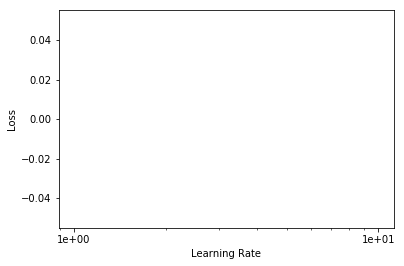

In [428]:
learn.recorder.plot()

In [429]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

In [80]:
learn.save('first_basic_toxic_lm_extended_15ep_mse')

In [68]:
learn.load('first_basic_toxic_lm_extended_15ep_mse');

In [268]:
learn.recorder.lrs[-1]

8.006106691150796e-08

In [269]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

In [274]:
learn.export('exported_reg_mse_toxic_lm_extended_15ep.pkl')

In [271]:
learn.save('second_basic_reg_mse_toxic_lm_extended_15ep')

In [338]:
learn.load('second_basic_reg_mse_toxic_lm_extended_15ep');

/opt/anaconda3/lib/python3.7/site-packages/fastai/basic_train.py:324: UserWarning: Wasn't able to properly load the optimizer state again.
  except: warn("Wasn't able to properly load the optimizer state again.")


In [350]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

learn.export('third_exported_reg_mse_2ep_toxic_lm_extended_15ep.pkl')

In [407]:
learn.save('third_basic_reg_mse_2ep_toxic_lm_extended_15ep')

In [341]:
learn.load('third_basic_reg_mse_2ep_toxic_lm_extended_15ep');

/opt/anaconda3/lib/python3.7/site-packages/fastai/basic_train.py:324: UserWarning: Wasn't able to properly load the optimizer state again.
  except: warn("Wasn't able to properly load the optimizer state again.")


# Predictions

In [345]:
learn.predict("I love jews, lesbians and gays, they are great!")

(FloatItem [0.466002], tensor([0.4660]), tensor([0.4660]))

In [148]:
data_path = Path('/home/jupyter/toxic/')
test_csv_file = 'toxic_test.csv'
test_df = pd.read_csv('/home/jupyter/toxic/toxic_test.csv')

In [ ]:
learn.data.add_test(test_df['comment_text'])

In [242]:
test_df.iloc[3]['comment_text']

'Instead of wringing our hands and nibbling the periphery of the issue, how about we face the actual issue head on? I would support a city ordinance against loitering, and applaud city councilors who champion a real and permanent solution.\n\nThe details could be determined, but would include a limit to persons sitting, standing, lying, smoking, conversing over a certain amount of time, perhaps 10 minutes. Exceptions, of course, would be for shopping, dining, attending a licensed and approved event, etc.\n\nIt is noble to provide some services for the truly needy in our community, but that, in my estimation, is a separate issue. I do not wish for my city to provide for nor encourage idle and harassing behaviors in our city core.\n\nEnough is enough!'

In [346]:
test_preds2 = learn.get_preds(ds_type=DatasetType.Test, ordered=True)

In [347]:
batch_preds = [pred[0] for pred in test_preds2[0].numpy()]

In [189]:
#np_prob_predictions = [x.numpy()[0] for x in prob_predictions] 

In [348]:
test_df['prediction'] = batch_preds

In [349]:
test_df[['id','prediction']].to_csv('batch_preds_toxic_reg_lm_extended_15ep.csv', index=False)

# Metrics

### Calculate bias on validation set

In [ ]:
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)

bias_metrics_df = compute_bias_metrics_for_model(validate_df, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df

In [ ]:
# class to do the same thing
class JigsawEvaluator:

    def __init__(self, y_true, y_identity, power=-5, overall_model_weight=0.25):
        self.y = (y_true >= 0.5).astype(int)
        self.y_i = (y_identity >= 0.5).astype(int)
        self.n_subgroups = self.y_i.shape[1]
        self.power = power
        self.overall_model_weight = overall_model_weight

    @staticmethod
    def _compute_auc(y_true, y_pred):
        try:
            return roc_auc_score(y_true, y_pred)
        except ValueError:
            return np.nan

    def _compute_subgroup_auc(self, i, y_pred):
        mask = self.y_i[:, i] == 1
        return self._compute_auc(self.y[mask], y_pred[mask])

    def _compute_bpsn_auc(self, i, y_pred):
        mask = self.y_i[:, i] + self.y == 1
        return self._compute_auc(self.y[mask], y_pred[mask])

    def _compute_bnsp_auc(self, i, y_pred):
        mask = self.y_i[:, i] + self.y != 1
        return self._compute_auc(self.y[mask], y_pred[mask])

    def compute_bias_metrics_for_model(self, y_pred):
        records = np.zeros((3, self.n_subgroups))
        for i in range(self.n_subgroups):
            records[0, i] = self._compute_subgroup_auc(i, y_pred)
            records[1, i] = self._compute_bpsn_auc(i, y_pred)
            records[2, i] = self._compute_bnsp_auc(i, y_pred)
        return records

    def _calculate_overall_auc(self, y_pred):
        return roc_auc_score(self.y, y_pred)

    def _power_mean(self, array):
        total = sum(np.power(array, self.power))
        return np.power(total / len(array), 1 / self.power)

    def get_final_metric(self, y_pred):
        bias_metrics = self.compute_bias_metrics_for_model(y_pred)
        bias_score = np.average([
            self._power_mean(bias_metrics[0]),
            self._power_mean(bias_metrics[1]),
            self._power_mean(bias_metrics[2])
        ])
        overall_score = self.overall_model_weight * self._calculate_overall_auc(y_pred)
        bias_score = (1 - self.overall_model_weight) * bias_score
        return overall_score + bias_score

### Calculate final metrics

In [ ]:
def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)
    
get_final_metric(bias_metrics_df, calculate_overall_auc(validate_df, MODEL_NAME))


In [1]:
import neptune

In [2]:
??neptune.create_experiment

Signature:
neptune.create_experiment(
    ['name=None', 'description=None', 'params=None', 'properties=None', 'tags=None', 'upload_source_files=None', 'abort_callback=None', 'upload_stdout=True', 'upload_stderr=True', 'send_hardware_metrics=True', 'run_monitoring_thread=True', 'handle_uncaught_exceptions=True', 'git_info=None', 'hostname=None'],
)
Docstring: <no docstring>
Source:   
def create_experiment(name=None,
                      description=None,
                      params=None,
                      properties=None,
                      tags=None,
                      upload_source_files=None,
                      abort_callback=None,
                      upload_stdout=True,
                      upload_stderr=True,
                      send_hardware_metrics=True,
                      run_monitoring_thread=True,
                      handle_uncaught_exceptions=True,
                      git_info=None,
                      hostname=None):
    # pylint: disable=global